In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imaterialist-fashion-2019-FGVC6:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F13032%2F862545%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240715%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240715T102704Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8b81ff144f657d9372716a72b880b9dbd35345831eb0fe3f7fe93dced2f3a40d23ee2b8181618cf6338552bf28c8bd4f4c18d89b2062929fd32cf96abc1be51d258f4e22619795f9ae62899bda4a6ce70f1cd95bc8657a50c52ca3fe4c5ffb3db993a481531dee93df86cd131f6c582f0729543460ac9f06cdd2655882b54997b8d337042ae5a290ae192c1eb5592f7ea34c1d6193e118c02f0cc35bd80820d4bcfa450fddd77fac4b28d05cc5aa37973911d564b24e8a86836efc6adac636bba94add08bc8b195c9a040fbb63024403f5c8dc1e577f80ebcdadf697fdf602049e7fe7352f5245b8491830cd920a9a0a1a804eca8555dfc4433e2ffa2d155e75'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 20503185382 bytes downloaded
Downloaded and uncompressed: imaterialist-fashion-2019-FGVC6
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:
df = pd.read_csv('/kaggle/input/imaterialist-fashion-2019-FGVC6/train.csv')

In [ ]:
with open("/kaggle/input/imaterialist-fashion-2019-FGVC6/label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
df['CategoryId'] = df['ClassId'].str.split('_').str[0]
df['AttributeId'] = df['ClassId'].str.split('_').str[1:]

print("Total segments: ", len(df))


Total segments:  331213


In [ ]:
def show_img(img):
    I = cv2.imread("/kaggle/input/train/" + img, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = cv2.resize(I, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
    plt.imshow(I)

In [ ]:
from skimage.transform import resize

def show_img(img):
    I = cv2.imread("/kaggle/input/imaterialist-fashion-2019-FGVC6/train/" + img, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = cv2.resize(I, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(I)

def get_mask(df, img_id):
    a = df[df.ImageId == img_id]
    a = a.groupby('CategoryId', as_index=False).agg({'EncodedPixels':' '.join, 'Height':'first','Width':'first'})
    H = a.iloc[0,2]
    W = a.iloc[0,3]
    masks =[]
    categories =[]
    for line in a[['EncodedPixels','CategoryId']].iterrows():
        mask = np.full(H*W,dtype='int',fill_value = 0)
        EncodedPixels = line[1][0]
        pixel_loc = list(map(int,EncodedPixels.split(' ')[0::2]))
        iter_num =  list(map(int,EncodedPixels.split(' ')[1::2]))
        for p,i in zip(pixel_loc,iter_num):
            mask[p:(p+i)] = line[1][1]
        mask = mask.reshape(W,H).T
        masks+=[mask]
        categories+=[line[1][1]]
    return masks, categories

def new_mask(mask):
    matrix = [[0 for x in range(512)] for y in range(512)]
    for i in range(0, len(mask)):
        mask[i] = cv2.resize(mask[i], (512, 512), interpolation=cv2.INTER_NEAREST)
    for m in mask:
        for i in range(0, 512):
            for j in range(0, 512):
                if m[i][j] != 0:
                    matrix[i][j]=m[i][j]
    matrix = np.array(matrix)
    return matrix

def masked_image(df, image_id):
    masked_list, categories = get_mask(df, image_id)
    plt.figure(figsize=[30,30])
    plt.subplot(1,10,1)
    I = cv2.imread("/kaggle/input/imaterialist-fashion-2019-FGVC6/train/" + image_id, cv2.IMREAD_COLOR)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I = cv2.resize(I, (512, 512), interpolation=cv2.INTER_AREA)
    plt.imshow(I)
    plt.title('Input Image')
    i=1
    gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    plt.imshow(I)
    for mask, cat in zip(masked_list, categories):
        mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        plt.subplot(1,10,i+1)
        plt.imshow(mask)
        plt.title(label_names[int(cat)])
        plt.subplots_adjust(wspace=0.4, hspace=-0.65)
        i+=1
        if i ==10:
            break
    new_mask_ = new_mask(masked_list)
    I[new_mask_ == 0] = 0
    plt.imshow(I)


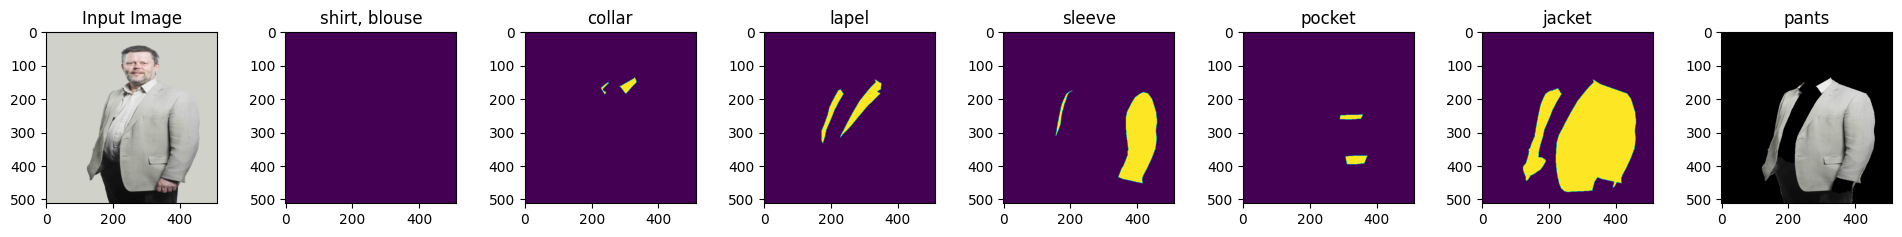

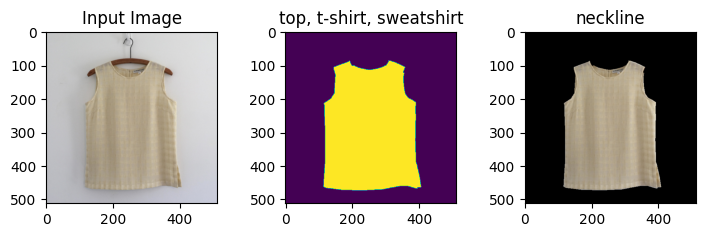

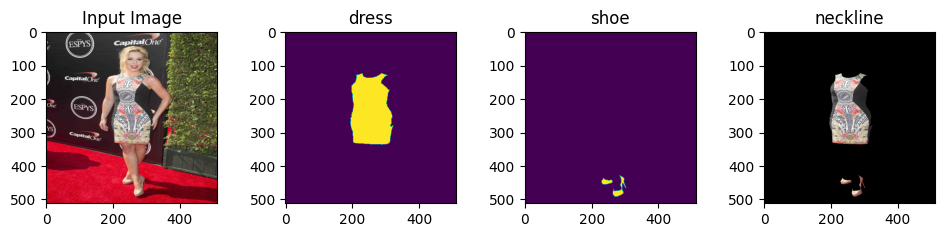

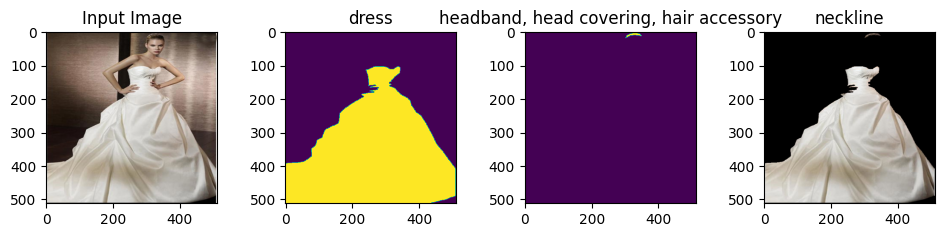

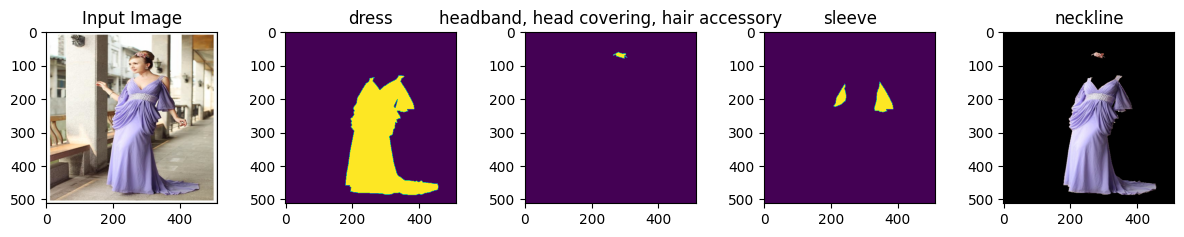

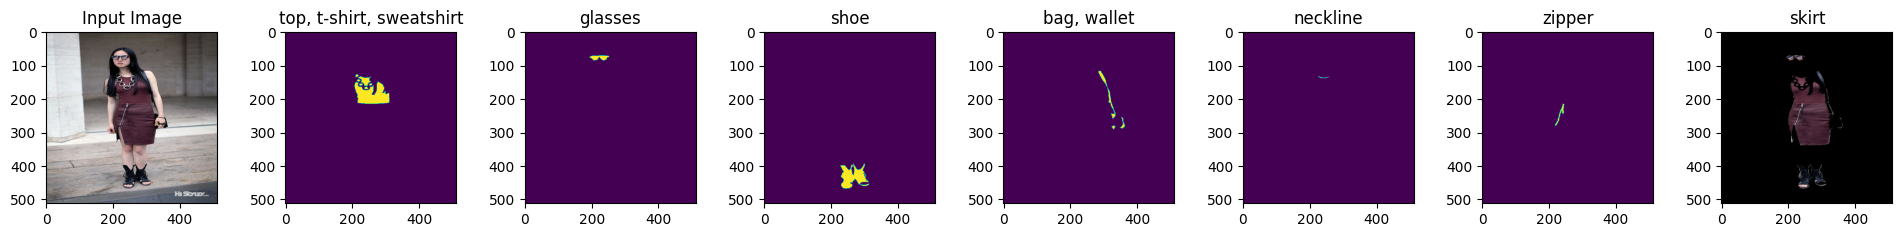

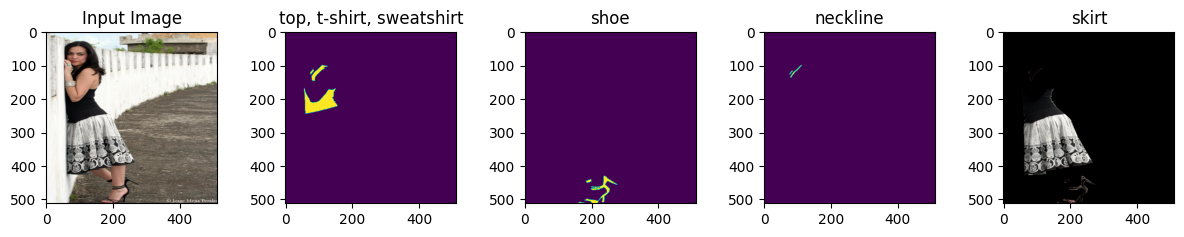

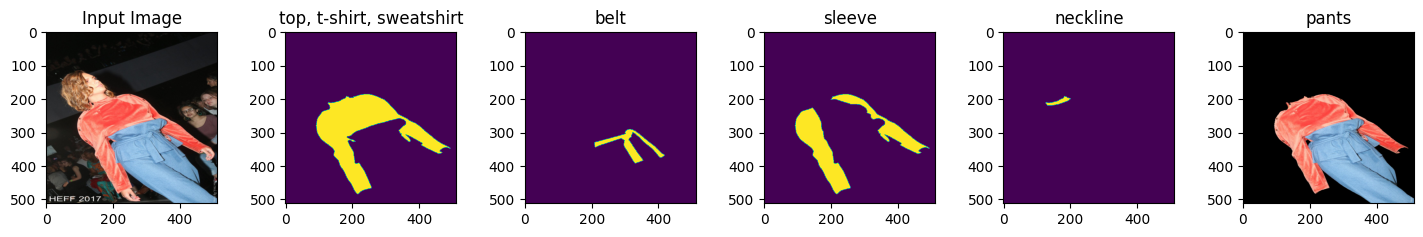

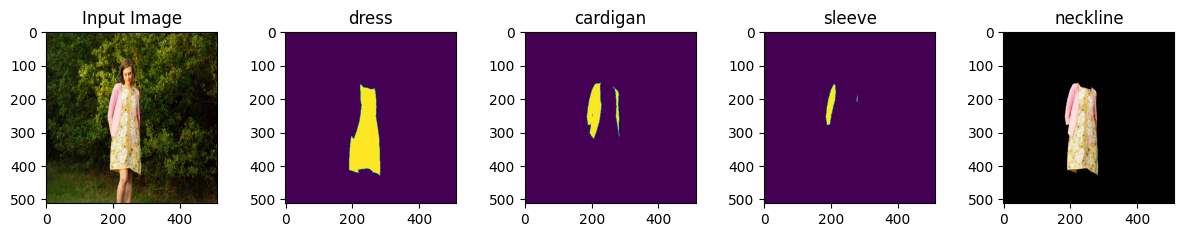

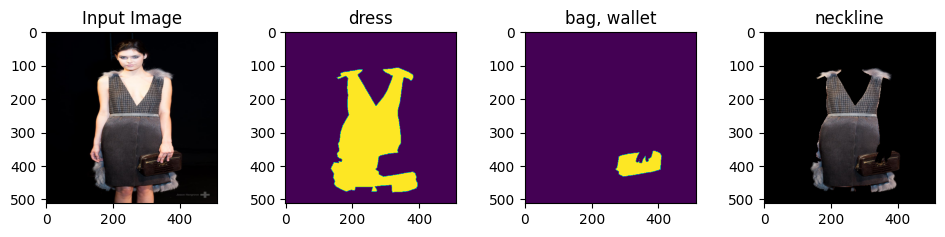

In [ ]:
ids = df['ImageId'].unique()
for idx in ids[0:10]:
    masked_image(df, idx)